In [82]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')
tf.config.run_functions_eagerly(True)

In [2]:
!gdown --id 1I53teiIjae-Bj98SgsiCzrcpqGd8fiS7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I53teiIjae-Bj98SgsiCzrcpqGd8fiS7
To: /content/hate.speech.csv
100% 651k/651k [00:00<00:00, 110MB/s]


In [4]:
df = pd.read_csv('hate_speech.csv')
df.head()

,speech,tweet_id,tweet_text
0,hate,61169928,@dabulls629 @Germ_Lerma id tackle u then proce...
1,hate,27620813,Listen here faggot slaves i feel sorry for u
2,hate,34369299,@DeeSophiscated_: I rl hate fat ugly dikes ple...
3,hate,34188944,@andrew_nunez @PubTranspoGuru tufts queers don...
4,hate,26045514,The way my dad is so deep... whenever I'm in t...


In [5]:
df.shape

(6219, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6219 entries, 0 to 6218
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speech      6219 non-null   object
 1   tweet_id    6219 non-null   int64 
 2   tweet_text  6219 non-null   object
dtypes: int64(1), object(2)
memory usage: 145.9+ KB


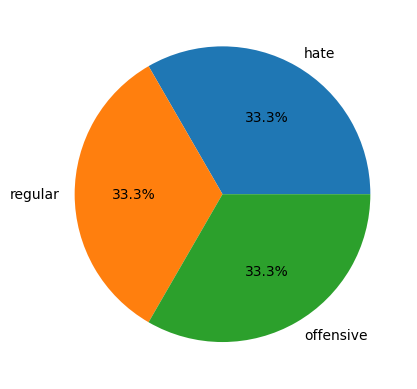

In [12]:
plt.pie(df['speech'].value_counts().values,
        labels = df['speech'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [11]:
# Adding class to the Dataframe
# 0 - Hate Speech
# 1 - Offensive Language
# 2 - Neither
label_mapping = {'hate': 0, 'offensive': 1, 'regular': 2}
df['class'] = df['speech'].map(label_mapping)

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
# Lower case all the words of the tweet before any preprocessing
df['tweet_text'] = df['tweet_text'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet_text']= df['tweet_text'].apply(lambda x: remove_punctuations(x))
df.head()

,speech,tweet_id,tweet_text,class
0,hate,61169928,dabulls629 germlerma id tackle u then proceed ...,0
1,hate,27620813,listen here faggot slaves i feel sorry for u,0
2,hate,34369299,deesophiscated i rl hate fat ugly dikes please...,0
3,hate,34188944,andrewnunez pubtranspoguru tufts queers dont k...,0
4,hate,26045514,the way my dad is so deep whenever im in town ...,0


In [21]:
# stopwords.words('english')

In [27]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():

        if word not in stop_words:

            # Let's Lemmatize the word as well
            # before appending to the imp_words list.

            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)

            imp_words.append(word)

    output = " ".join(imp_words)

    return output

In [31]:
df['tweet_text'] = df['tweet_text'].apply(lambda text: remove_stopwords(text))
df.head()

,speech,tweet_id,tweet_text,class
0,hate,61169928,dabulls629 germlerma id tackle u proceed deadl...,0
1,hate,27620813,listen faggot slaves feel sorry u,0
2,hate,34369299,deesophiscated rl hate fat ugly dikes please d...,0
3,hate,34188944,andrewnunez pubtranspoguru tufts queers dont k...,0
4,hate,26045514,way dad deep whenever im town kgalemela nigger...,0


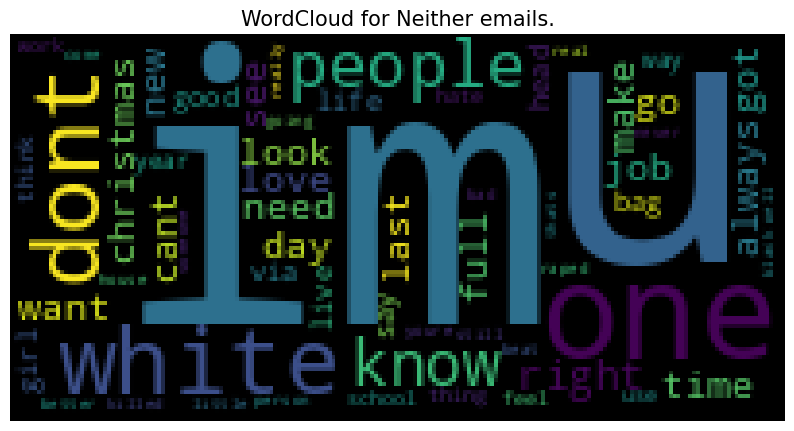

In [35]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet_text'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')
# plot_word_cloud(df[df['class']==1], typ='offensive')
# plot_word_cloud(df[df['class']==0], typ='hate')

In [63]:
# Training and Validation data
features = df['tweet_text']
target = df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size=0.2,
                                                  random_state=22)
X_train.shape, X_val.shape

((4975,), (1244,))

In [64]:
# Word2Vec Conversion using One Hot Encoding
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((4975, 3), (1244, 3))

In [65]:
X_train.head()

2922    odd fact year texas tech beat every qb thrown ...
4278                         ctvkitchener whip faggot ass
2291    defiantly agree look stunning shaymitch httpst...
1067    kaetzchenlouis words fag dyke like thrown arou...
2780        ive got fear running fags many buy 30 30 good
Name: tweet_text, dtype: object

In [66]:
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

In [67]:
#Generating token embeddings
Training_seq = tokenizer.texts_to_sequences(X_train)
Val_seq = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(Training_seq, maxlen=max_len,padding='post',truncating='post')
X_val = pad_sequences(Val_seq, maxlen=max_len,padding='post',truncating='post')

In [68]:
X_train.shape

(4975, 100)

In [69]:
X_val.shape

(1244, 100)

In [59]:
# Model
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               6272      
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

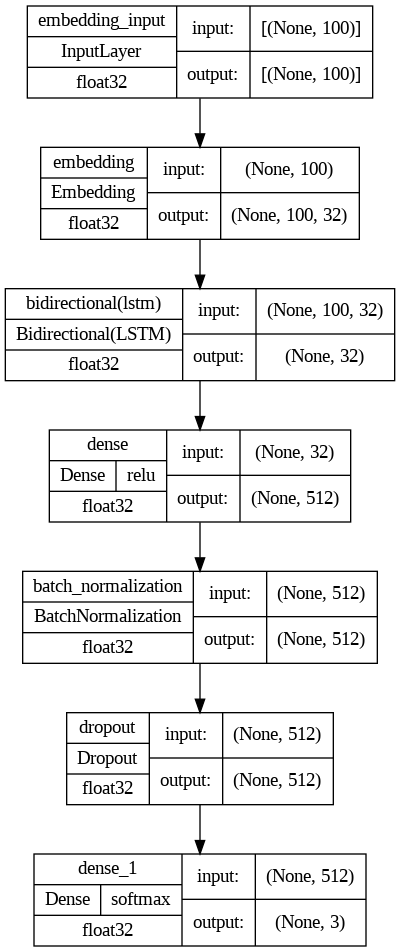

In [60]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [61]:
# callback
# These are checked if the model is improving
# Steps can be taken like ReductedLROnPlateau
# EarlyStopping
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [72]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((4975, 100), (1244, 100), (4975, 3), (1244, 3))

In [83]:
# training the model
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50
156/156 [==============================] - 136s 871ms/step - loss: 2.9200 - accuracy: 0.5678 - val_loss: 1.2443 - val_accuracy: 0.3408 - lr: 0.0010
Epoch 2/50
156/156 [==============================] - 125s 804ms/step - loss: 0.6497 - accuracy: 0.7315 - val_loss: 1.1468 - val_accuracy: 0.3465 - lr: 0.0010
Epoch 3/50
156/156 [==============================] - 132s 850ms/step - loss: 0.5120 - accuracy: 0.8171 - val_loss: 0.9732 - val_accuracy: 0.5225 - lr: 0.0010
Epoch 4/50
156/156 [==============================] - 124s 795ms/step - loss: 0.4052 - accuracy: 0.8637 - val_loss: 0.7894 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 5/50
156/156 [==============================] - 132s 844ms/step - loss: 0.3402 - accuracy: 0.8953 - val_loss: 0.8533 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 6/50
156/156 [==============================] - 132s 847ms/step - loss: 0.2974 - accuracy: 0.9083 - val_loss: 1.0115 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 7/50
156/156 [==========================

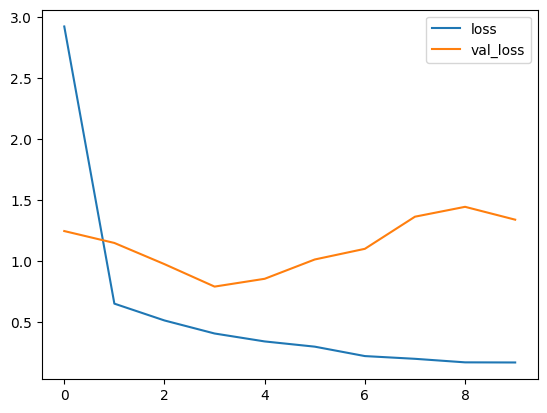

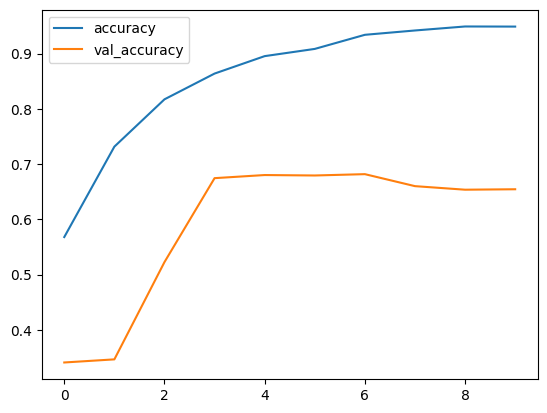

In [84]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()